## Импорт библиотек и загрузка исходных данных

In [453]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

import optuna

from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import  log_loss

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score

Данные в этом соревновании сгенерированы на основе датасета из другого соревнования. origin - это как раз реальные данные из того соревнования.

In [454]:
train = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv')
origin = pd.read_csv('/kaggle/input/cirrhosis-patient-survival-prediction/cirrhosis.csv')
test_id = test['id']
origin.drop('ID', axis = 1, inplace = True)
train.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)

# EDA

Посмотрим на распределение значений целевой переменной. Поскольку C и CL достаточно близки, получаем распределение примерно 65% на 35%. Можно считать, что сильного дисбаланса классов нет.

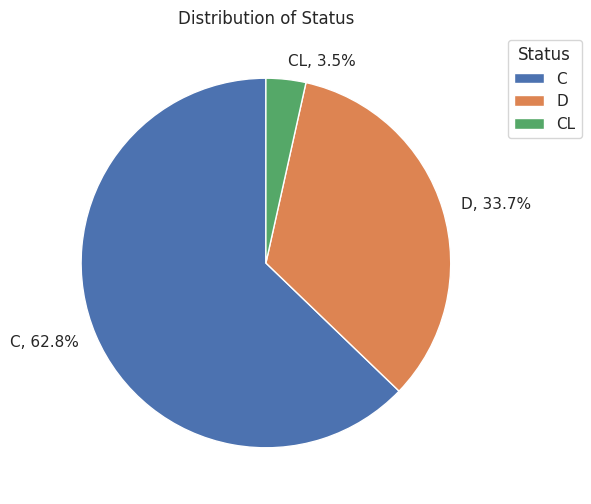

In [455]:
# Counting the observations for each category
LABEL = 'Status'
status_counts = train[LABEL].value_counts()
labels = status_counts.index
sizes = status_counts.values

# Calculating the percentage of each category
percentages = 100.*sizes/sizes.sum()

# Creating the pie chart with percentages in the labels
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=[f"{l}, {s:.1f}%" for l, s in zip(labels, percentages)], startangle=90)
plt.gca().set_aspect("equal")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), labels=labels, title=LABEL)
plt.title(f"Distribution of {LABEL}")
plt.show()

Матрица корреляции показывает, что слишком сильно скоррелированных признаков нет. Максимальное по модулю значение коэффициента корреляции - 0.44.

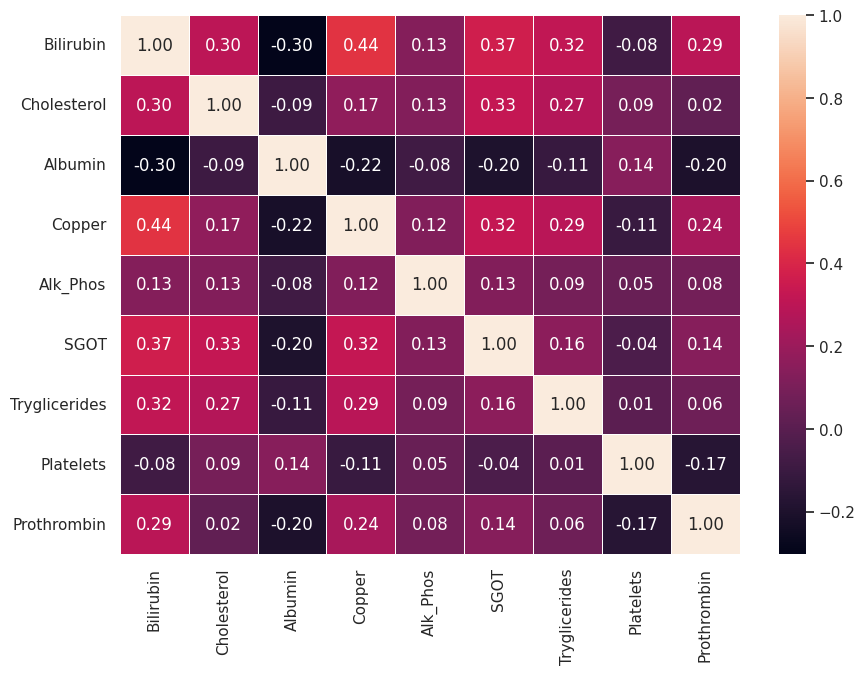

In [456]:
selected_features = [
    
    'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
    'Tryglicerides', 'Platelets', 'Prothrombin'
]

# Create a subset correlation matrix for the selected features
subset_correlation_matrix = train[selected_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    subset_correlation_matrix,
    annot=True,
    fmt=".2f",
    linewidths=.5
)

plt.show()

Ниже построены графики типа boxplot для распредления числовых признаков для каждого класса. Видно, что есть экстремальные значения, которые лучше обработать.

In [457]:
def scatter_box_plot(data_set=None, num_vars=None, target=None):
    if data_set is None or num_vars is None or target is None:
        raise ValueError("Please provide data_set and variables.")
    num_rows = len(num_vars)
    num_cols = 3 
    
    total_plots = num_rows*num_cols
    plt.figure(figsize=(14,num_rows*4))
    
    for idx, col in enumerate(num_vars):
        plt.subplot(num_rows, num_cols, idx % total_plots + 1)
        sns.boxplot(x=target, y=col, data=train, color='#82B0D2',hue=target)
        

        plt.title(f"{col} : {target}")

    plt.tight_layout()
    plt.show()    

In [458]:
feature_cols = [c for c in train.columns if c != LABEL]
num_cols = train[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

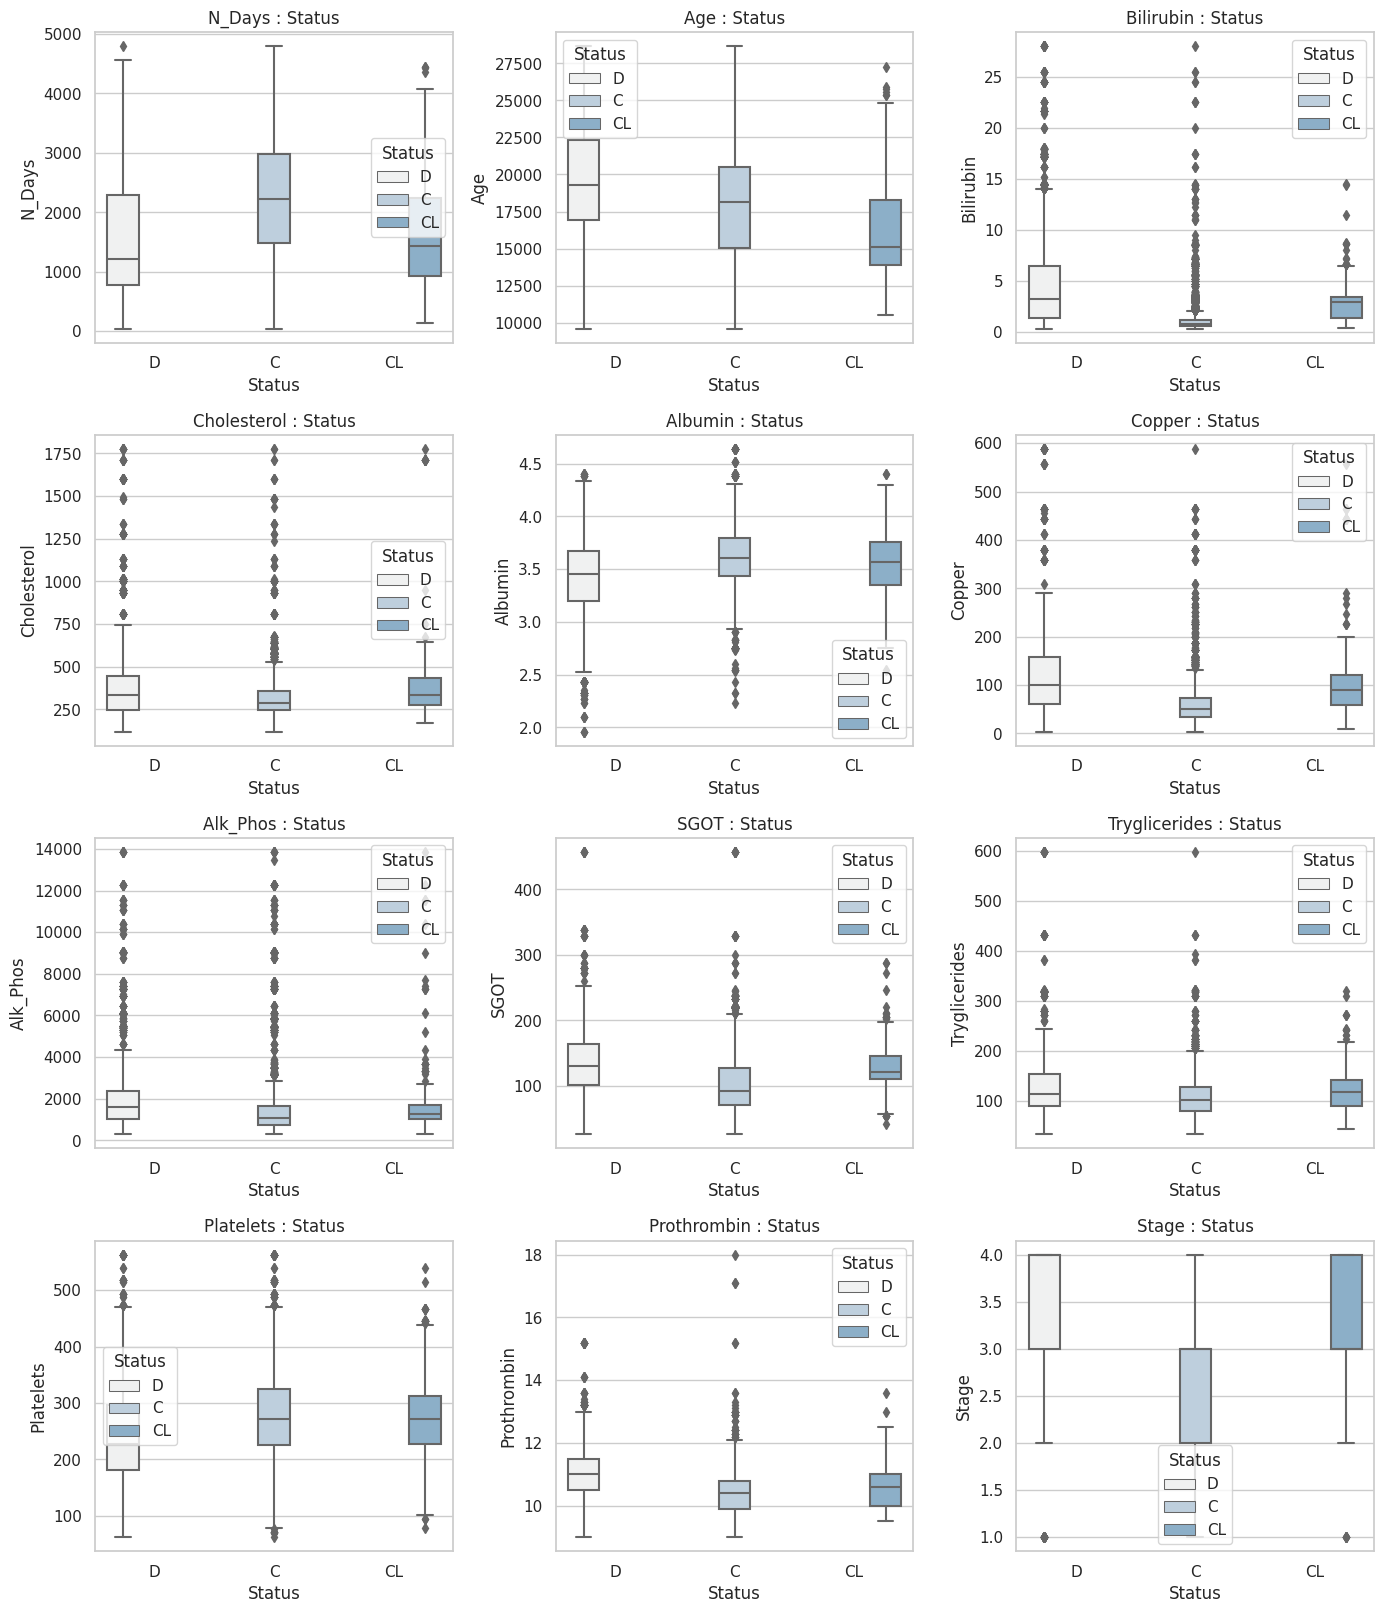

In [459]:
scatter_box_plot(data_set=train, num_vars=num_cols, target=LABEL)

Ниже также приведены графики распределения числовых признаков. Из них видно, что большинство признаков имеют близкое к нормальному распределение, при этом параметры распределения отличаются в зависимости от класса.

In [460]:
def distribution_box_plot(data_set=None, variables=None, target=None):
    if data_set is None or variables is None:
        raise ValueError("Please provide data_set and variables.")
    
    fig, axes = plt.subplots(len(variables), 1, figsize=(16, len(variables) * 4.2), 
                             gridspec_kw={'hspace': 0.35, 'wspace': 0.3})
    for i, col in enumerate(variables):
        ax = axes[i]
        sns.histplot(data=data_set, hue=target,x=col, bins=30, kde=True, ax=ax, linewidth=2.1, color='lightblue')
        ax.set_title(f"\n{col}", fontsize=15, fontweight='bold')
        ax.grid(visible=True, which='both', linestyle='--', linewidth=0.75)

        #ax = axes[i, 1]
        #sns.boxplot(x=target, data=data_set, y=col, width=0.25, saturation=0.90, hue=target,
        #            linewidth=0.90, fliersize=2.25, color='lightblue', ax=ax)
        #ax.set(xlabel='', ylabel='')
        #ax.set_title(f"Train", fontsize=15, fontweight='bold')

    plt.tight_layout()
    plt.show()

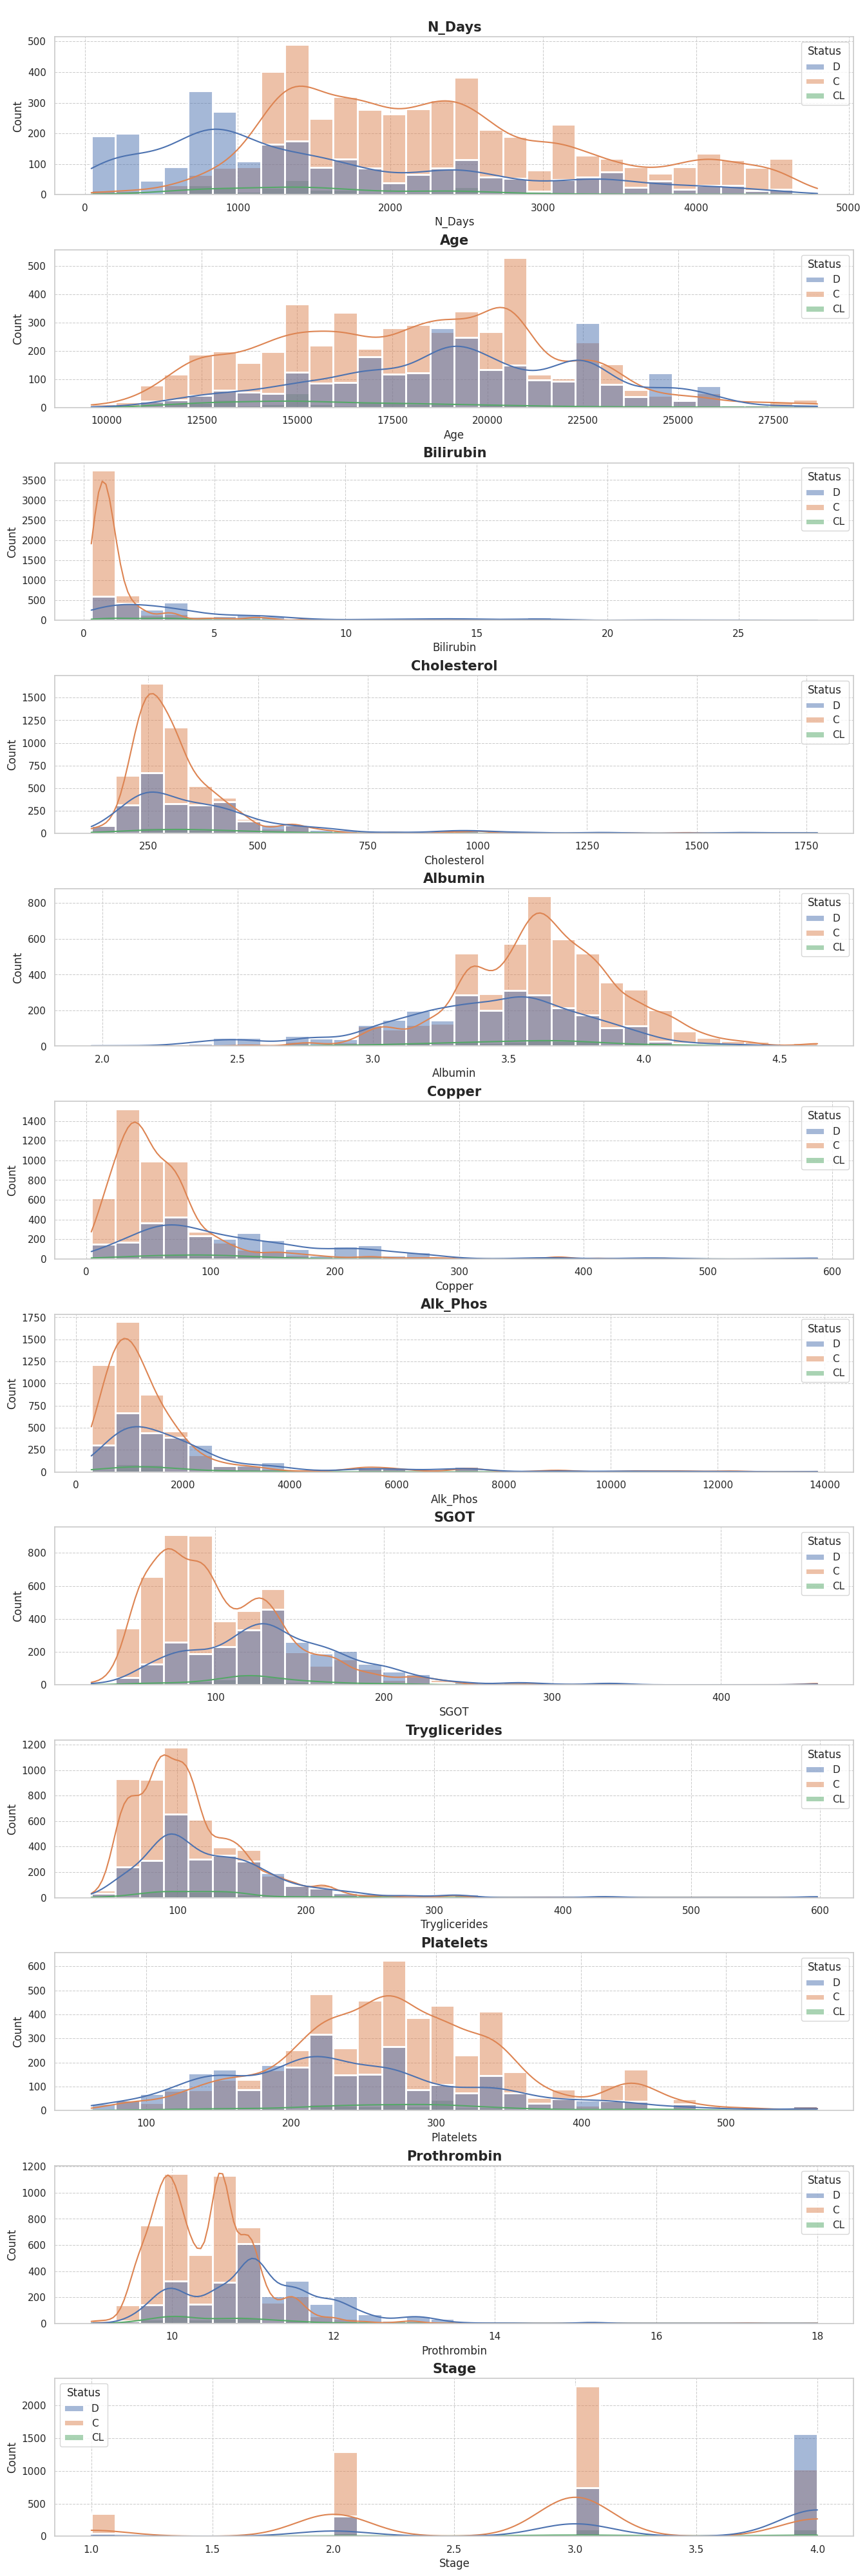

In [461]:
distribution_box_plot(data_set=train,variables=num_cols,target=LABEL)

# Предобработка данных

## Проверка на NAN везде

In [462]:
def show_missing(df, name):
    miss = df.isna().sum().sort_values(ascending=False)
    miss = miss[miss > 0]
    print(f"\n{name}: total missing = {df.isna().sum().sum()}")
    if len(miss) == 0:
        print("No missing values")
    else:
        display(miss.to_frame("missing_count"))

show_missing(train, "train")
show_missing(test, "test")
show_missing(origin, "origin")


train: total missing = 0
No missing values

test: total missing = 0
No missing values

origin: total missing = 1033


,missing_count
Tryglicerides,136
Cholesterol,134
Copper,108
Drug,106
Ascites,106
Hepatomegaly,106
Spiders,106
SGOT,106
Alk_Phos,106
Platelets,11


In [463]:
def fill_missing_by_train_stats(train_df, test_df, origin_df, target_col="Status"):
    feature_cols = [c for c in train_df.columns if c != target_col]
    num_cols = train_df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in feature_cols if c not in num_cols]

    medians = train_df[num_cols].median()

    modes = {}
    for c in cat_cols:
        m = train_df[c].mode(dropna=True)
        modes[c] = m.iloc[0] if len(m) else "Unknown"

    def apply_fill(df):
        df = df.copy()
        df[num_cols] = df[num_cols].fillna(medians)
        for c in cat_cols:
            df[c] = df[c].fillna(modes[c])
        return df

    return apply_fill(train_df), apply_fill(test_df), apply_fill(origin_df)

train, test, origin = fill_missing_by_train_stats(train, test, origin, target_col="Status")
show_missing(origin, "origin after fill")
assert origin.isna().sum().sum() == 0


origin after fill: total missing = 0
No missing values


In [464]:
def clip_outliers_by_train_quantiles(train_df, test_df, origin_df, target_col="Status", low_q=0.01, high_q=0.99):
    feature_cols = [c for c in train_df.columns if c != target_col]
    num_cols = train_df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

    lo = train_df[num_cols].quantile(low_q)
    hi = train_df[num_cols].quantile(high_q)

    def apply_clip(df):
        df = df.copy()
        df[num_cols] = df[num_cols].clip(lower=lo, upper=hi, axis=1)
        return df

    return apply_clip(train_df), apply_clip(test_df), apply_clip(origin_df)

## Сколько значений было обрезано

In [465]:
train_before = train.copy()
test_before  = test.copy()
origin_before = origin.copy()

train, test, origin = clip_outliers_by_train_quantiles(
    train, test, origin,
    target_col="Status",
    low_q=0.001, high_q=0.999
)

print("Clipped values in train :", (train_before.select_dtypes(np.number)  != train.select_dtypes(np.number)).sum().sum())
print("Clipped values in test  :", (test_before.select_dtypes(np.number)   != test.select_dtypes(np.number)).sum().sum())
print("Clipped values in origin:", (origin_before.select_dtypes(np.number) != origin.select_dtypes(np.number)).sum().sum())

Clipped values in train : 34
Clipped values in test  : 32
Clipped values in origin: 9


## Кодирование признаков

In [466]:
class LabelEncoding:
    def __init__(self, train: pd.DataFrame,
                       test: pd.DataFrame,
                       origin: pd.DataFrame,
                       categorical_features : list[str] = []
                ):
        self.train = train
        self.test = test
        self.origin = origin
        self.categorical_features = categorical_features
        self.col_values = {col : train[col].unique().tolist() for col in self.categorical_features}

    def encode(self, custom = False, weights : dict[str, list[float]] = {}):
        if not custom:
            weights = {col : list(range(len(train[col].unique()))) for col in self.categorical_features}
        for col in self.categorical_features:
            self.origin[col] = self.origin[col].replace(self.col_values[col], weights[col])
            self.train[col] = self.train[col].replace(self.col_values[col], weights[col])
            self.test[col] = self.test[col].replace(self.col_values[col], weights[col])

        return self.train, self.test, self.origin

lbe = LabelEncoding(train, test, origin, ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'])
lbe_train, lbe_test, lbe_origin = lbe.encode()

## Feature engineering

In [467]:
lbe_train_origin = pd.concat([lbe_train, lbe_origin])
lbe_train_origin['Status'] = lbe_train_origin['Status'].map({"D": 0,"C": 1,"CL": 2})

lbe_train_origin['date_of_diagnosis'] = lbe_train_origin['Age'] - lbe_train_origin['N_Days']
lbe_train_origin['diseases'] = lbe_train_origin['Ascites'] + lbe_train_origin['Hepatomegaly'] + lbe_train_origin['Spiders'] + lbe_train_origin['Edema']

lbe_test['date_of_diagnosis'] = lbe_test['Age'] - lbe_test['N_Days']
lbe_test['diseases'] = lbe_test['Ascites'] + lbe_test['Hepatomegaly'] + lbe_test['Spiders'] + lbe_test['Edema']

In [468]:
normal_ranges = {
        'Bilirubin': (0.1, 1.2),
        'Alk_Phos': (40, 129),
}

def add_is_normal_features(df, normal_ranges):
        for feature, (normal_range_min, normal_range_max) in normal_ranges.items():
            if feature == 'Platelets':
                df[f'{feature}_is_normal'] = (df[feature] >= normal_range_min) & (df[feature] <= normal_range_max)
            elif feature == 'Albumin':
                df[f'{feature}_is_normal'] = (df[feature] >= normal_range_min)
            else:
                df[f'{feature}_is_normal'] = (df[feature] <= normal_range_max)
        
            # Add deviation calculation
            df[f'{feature}_deviation'] = (df[feature] - ((normal_range_min + normal_range_max) / 2)) * (1 - df[f'{feature}_is_normal'])

In [469]:
add_is_normal_features(lbe_train_origin, normal_ranges)
add_is_normal_features(lbe_test, normal_ranges)

# Выбор модели

In [470]:
X, y = lbe_train_origin.drop('Status', axis = 1), lbe_train_origin['Status']

In [471]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.85, random_state = 2610, stratify = y)

In [472]:
def objective_xgb(trial):

    params = {
              'objective': 'multiclass',
              'num_class': 3,
              'max_depth': trial.suggest_int('max_depth', 15, 20),
              'min_child_samples': trial.suggest_int('min_child_samples', 20, 50),
              'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.04),
              'n_estimators': trial.suggest_int('n_estimators', 350, 600),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'subsample': trial.suggest_float('subsample', 0.85, 1.0),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
              'reg_alpha': trial.suggest_float('reg_alpha', 0.85, 1.0),
              'reg_lambda': trial.suggest_float('reg_lambda', 0.85, 1.0),
              'random_state': 42
            }

    model = XGBClassifier(**params, verbose=-1)

    scores = cross_val_score(model, X, y, cv=5, scoring='neg_log_loss')

    return -scores.mean()

In [473]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective_xgb , n_trials=2) 

# best_params2 = study.best_params
# print('Best params:' , best_params2)

## Финальное предсказание

In [474]:
xgb_params = {
    'max_depth': 13,
    'min_child_samples': 31,
    'learning_rate': 0.0395383927057413,
    'n_estimators': 503,
    'min_child_weight': 3,
    'subsample': 0.9535160985162805,
    'colsample_bytree': 0.11468454920399618,
    'reg_alpha': 0.9997937938478979,
    'reg_lambda': 0.9868829116545746
    }

In [475]:
xgb_model = XGBClassifier(**xgb_params)
xgb_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.11468454920399618, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0395383927057413,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_samples=31, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=503,
              n_jobs=None, num_parallel_tree=None, ...)

In [476]:
log_loss(y_test, xgb_model.predict_proba(X_test))

0.19265977388233774

In [477]:
preds = xgb_model.predict_proba(lbe_test)
preds = pd.DataFrame(preds, columns = ['D', 'C', 'CL'])
sub = pd.DataFrame(test_id)
sub['Status_C'] = preds['C']
sub['Status_CL'] = preds['CL']
sub['Status_D'] = preds['D']

sub.to_csv('submission.csv', index = False)
sub

,id,Status_C,Status_CL,Status_D
0,7905,0.293320,0.027661,0.679019
1,7906,0.566635,0.128943,0.304422
2,7907,0.019243,0.004693,0.976064
3,7908,0.967024,0.003493,0.029483
4,7909,0.917684,0.038406,0.043910
...,...,...,...,...
5266,13171,0.866040,0.081176,0.052783
5267,13172,0.980267,0.003596,0.016137
5268,13173,0.974590,0.008503,0.016907
5269,13174,0.977970,0.008831,0.013199


# Анализ Feature importance

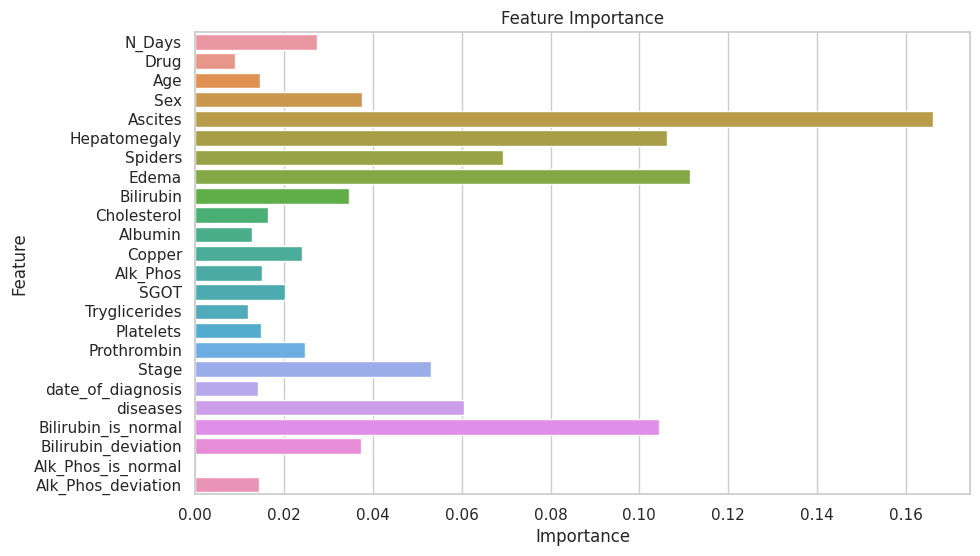

In [478]:
importances = xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=X.columns)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
